# Method 7 - Rest Ideas After 5

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 5].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

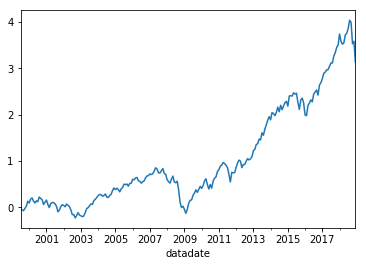

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.134534
2000-12-31   -0.019992
2001-12-31   -0.047720
2002-12-31   -0.209685
2003-12-31    0.449587
2004-12-31    0.172124
2005-12-31    0.072128
2006-12-31    0.106503
2007-12-31    0.017899
2008-12-31   -0.401847
2009-12-31    0.416391
2010-12-31    0.220644
2011-12-31   -0.013884
2012-12-31    0.194421
2013-12-31    0.413976
2014-12-31    0.111519
2015-12-31   -0.010677
2016-12-31    0.133621
2017-12-31    0.221712
2018-12-31   -0.083642
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     3061.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.85e-197
Time:                        22:32:35   Log-Likelihood:                 845.44
No. Observations:                 234   AIC:                            -1681.
Df Residuals:                     229   BIC:                            -1664.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.791      0.000       0.001       0.003
mktrf          1.0236      0.012     83.190      0.000       0.999       1.048
me             0.2492      0.014     17.410      0.000       0.221       0.277
ia             0.0549      0.022      2.523      0.012       0.012       0.098
roe           -0.0209      0.019     -1.124      0.262      -0.058       0.016
==============================================================================
Omnibus:                       26.062   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.990
Skew:                          -0.164   Prob(JB):                     5.34e-27
Kurtosis:                       6.507   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2065.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.48e-178
Time:                        22:32:35   Log-Likelihood:                 845.44
No. Observations:                 234   AIC:                            -1681.
Df Residuals:                     229   BIC:                            -1664.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.718      0.000       0.001       0.003
mktrf          1.0236      0.015     67.330      0.000       0.994       1.053
me             0.2492      0.024     10.206      0.000       0.201       0.297
ia             0.0549      0.046      1.200      0.230      -0.035       0.145
roe           -0.0209      0.027     -0.775      0.438      -0.074       0.032
==============================================================================
Omnibus:                       26.062   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.990
Skew:                          -0.164   Prob(JB):                     5.34e-27
Kurtosis:                       6.507   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2393.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.79e-185
Time:                        22:32:35   Log-Likelihood:                 845.44
No. Observations:                 234   AIC:                            -1681.
Df Residuals:                     229   BIC:                            -1664.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.921      0.000       0.001       0.003
mktrf          1.0236      0.015     67.735      0.000       0.994       1.053
me             0.2492      0.022     11.151      0.000       0.205       0.293
ia             0.0549      0.048      1.151      0.250      -0.039       0.148
roe           -0.0209      0.030     -0.699      0.485      -0.080       0.038
==============================================================================
Omnibus:                       26.062   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.990
Skew:                          -0.164   Prob(JB):                     5.34e-27
Kurtosis:                       6.507   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2066.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.20e-187
Time:                        22:32:35   Log-Likelihood:                 826.43
No. Observations:                 234   AIC:                            -1641.
Df Residuals:                     228   BIC:                            -1620.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      3.857      0.000       0.001       0.003
mktrf          1.0346      0.013     77.204      0.000       1.008       1.061
smb            0.2745      0.018     15.522      0.000       0.240       0.309
hml            0.0265      0.021      1.272      0.205      -0.015       0.068
rmw           -0.0006      0.024     -0.025      0.980      -0.047       0.046
cma            0.0345      0.030      1.151      0.251      -0.025       0.094
==============================================================================
Omnibus:                       25.982   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.017
Skew:                           0.055   Prob(JB):                     5.85e-29
Kurtosis:                       6.650   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1530.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.75e-173
Time:                        22:32:35   Log-Likelihood:                 826.43
No. Observations:                 234   AIC:                            -1641.
Df Residuals:                     228   BIC:                            -1620.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.701      0.000       0.001       0.003
mktrf          1.0346      0.017     61.338      0.000       1.002       1.068
smb            0.2745      0.023     11.974      0.000       0.230       0.319
hml            0.0265      0.045      0.591      0.554      -0.061       0.114
rmw           -0.0006      0.029     -0.021      0.983      -0.057       0.056
cma            0.0345      0.048      0.716      0.474      -0.060       0.129
==============================================================================
Omnibus:                       25.982   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.017
Skew:                           0.055   Prob(JB):                     5.85e-29
Kurtosis:                       6.650   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1952.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.59e-185
Time:                        22:32:35   Log-Likelihood:                 826.43
No. Observations:                 234   AIC:                            -1641.
Df Residuals:                     228   BIC:                            -1620.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.656      0.000       0.001       0.003
mktrf          1.0346      0.016     62.801      0.000       1.002       1.067
smb            0.2745      0.022     12.584      0.000       0.232       0.317
hml            0.0265      0.047      0.562      0.574      -0.066       0.119
rmw           -0.0006      0.031     -0.019      0.985      -0.061       0.060
cma            0.0345      0.047      0.738      0.460      -0.057       0.126
==============================================================================
Omnibus:                       25.982   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.017
Skew:                           0.055   Prob(JB):                     5.85e-29
Kurtosis:                       6.650   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2344.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.77e-184
Time:                        22:32:35   Log-Likelihood:                 814.90
No. Observations:                 234   AIC:                            -1620.
Df Residuals:                     229   BIC:                            -1603.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      4.206      0.000       0.001       0.003
mktrf          1.0279      0.013     79.633      0.000       1.002       1.053
smb            0.2599      0.016     16.130      0.000       0.228       0.292
hml            0.0900      0.016      5.625      0.000       0.058       0.122
umd           -0.0095      0.011     -0.904      0.367      -0.030       0.011
==============================================================================
Omnibus:                       26.283   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.883
Skew:                           0.082   Prob(JB):                     2.30e-29
Kurtosis:                       6.674   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1892.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.29e-174
Time:                        22:32:35   Log-Likelihood:                 814.90
No. Observations:                 234   AIC:                            -1620.
Df Residuals:                     229   BIC:                            -1603.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.389      0.001       0.001       0.003
mktrf          1.0279      0.018     57.717      0.000       0.993       1.063
smb            0.2599      0.024     10.817      0.000       0.213       0.307
hml            0.0900      0.048      1.881      0.060      -0.004       0.184
umd           -0.0095      0.019     -0.499      0.618      -0.047       0.028
==============================================================================
Omnibus:                       26.283   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.883
Skew:                           0.082   Prob(JB):                     2.30e-29
Kurtosis:                       6.674   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2392.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.84e-185
Time:                        22:32:35   Log-Likelihood:                 814.90
No. Observations:                 234   AIC:                            -1620.
Df Residuals:                     229   BIC:                            -1603.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.288      0.001       0.001       0.003
mktrf          1.0279      0.015     66.854      0.000       0.998       1.058
smb            0.2599      0.025     10.482      0.000       0.211       0.308
hml            0.0900      0.053      1.697      0.090      -0.014       0.194
umd           -0.0095      0.015     -0.622      0.534      -0.039       0.020
==============================================================================
Omnibus:                       26.283   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.883
Skew:                           0.082   Prob(JB):                     2.30e-29
Kurtosis:                       6.674   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1383.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.29e-96
Time:                        22:32:35   Log-Likelihood:                 415.43
No. Observations:                 120   AIC:                            -820.9
Df Residuals:                     115   BIC:                            -806.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.692      0.000       0.001       0.004
mktrf          1.0304      0.020     51.560      0.000       0.991       1.070
me             0.2311      0.020     11.705      0.000       0.192       0.270
ia             0.0991      0.031      3.205      0.002       0.038       0.160
roe           -0.0215      0.027     -0.785      0.434      -0.076       0.033
==============================================================================
Omnibus:                        9.839   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               22.524
Skew:                          -0.120   Prob(JB):                     1.29e-05
Kurtosis:                       5.109   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1151.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.00e-91
Time:                        22:32:35   Log-Likelihood:                 415.43
No. Observations:                 120   AIC:                            -820.9
Df Residuals:                     115   BIC:                            -806.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.454      0.001       0.001       0.004
mktrf          1.0304      0.025     41.485      0.000       0.982       1.079
me             0.2311      0.024      9.589      0.000       0.184       0.278
ia             0.0991      0.049      2.028      0.043       0.003       0.195
roe           -0.0215      0.031     -0.687      0.492      -0.083       0.040
==============================================================================
Omnibus:                        9.839   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               22.524
Skew:                          -0.120   Prob(JB):                     1.29e-05
Kurtosis:                       5.109   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1767.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.28e-102
Time:                        22:32:35   Log-Likelihood:                 415.43
No. Observations:                 120   AIC:                            -820.9
Df Residuals:                     115   BIC:                            -806.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.372      0.001       0.001       0.004
mktrf          1.0304      0.022     46.938      0.000       0.987       1.073
me             0.2311      0.022     10.410      0.000       0.188       0.275
ia             0.0991      0.044      2.263      0.024       0.013       0.185
roe           -0.0215      0.032     -0.663      0.507      -0.085       0.042
==============================================================================
Omnibus:                        9.839   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               22.524
Skew:                          -0.120   Prob(JB):                     1.29e-05
Kurtosis:                       5.109   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     895.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.06e-89
Time:                        22:32:35   Log-Likelihood:                 403.53
No. Observations:                 120   AIC:                            -795.1
Df Residuals:                     114   BIC:                            -778.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.470      0.001       0.001       0.005
mktrf          1.0729      0.023     45.902      0.000       1.027       1.119
smb            0.2751      0.026     10.390      0.000       0.223       0.328
hml            0.0021      0.032      0.066      0.948      -0.062       0.066
rmw            0.0357      0.038      0.933      0.353      -0.040       0.111
cma            0.1020      0.042      2.435      0.016       0.019       0.185
==============================================================================
Omnibus:                       12.329   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               35.465
Skew:                          -0.117   Prob(JB):                     1.99e-08
Kurtosis:                       5.653   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1001.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.15e-92
Time:                        22:32:35   Log-Likelihood:                 403.53
No. Observations:                 120   AIC:                            -795.1
Df Residuals:                     114   BIC:                            -778.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.330      0.001       0.001       0.005
mktrf          1.0729      0.031     34.774      0.000       1.012       1.133
smb            0.2751      0.035      7.938      0.000       0.207       0.343
hml            0.0021      0.074      0.029      0.977      -0.142       0.146
rmw            0.0357      0.056      0.635      0.526      -0.074       0.146
cma            0.1020      0.058      1.763      0.078      -0.011       0.215
==============================================================================
Omnibus:                       12.329   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               35.465
Skew:                          -0.117   Prob(JB):                     1.99e-08
Kurtosis:                       5.653   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1857.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.98e-107
Time:                        22:32:35   Log-Likelihood:                 403.53
No. Observations:                 120   AIC:                            -795.1
Df Residuals:                     114   BIC:                            -778.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.373      0.001       0.001       0.005
mktrf          1.0729      0.029     37.133      0.000       1.016       1.130
smb            0.2751      0.034      8.178      0.000       0.209       0.341
hml            0.0021      0.079      0.027      0.979      -0.153       0.157
rmw            0.0357      0.060      0.590      0.555      -0.083       0.154
cma            0.1020      0.056      1.821      0.069      -0.008       0.212
==============================================================================
Omnibus:                       12.329   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               35.465
Skew:                          -0.117   Prob(JB):                     1.99e-08
Kurtosis:                       5.653   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     977.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.32e-88
Time:                        22:32:35   Log-Likelihood:                 395.11
No. Observations:                 120   AIC:                            -780.2
Df Residuals:                     115   BIC:                            -766.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.037      0.000       0.002       0.005
mktrf          1.0404      0.021     49.886      0.000       0.999       1.082
smb            0.2526      0.024     10.639      0.000       0.206       0.300
hml            0.1131      0.024      4.757      0.000       0.066       0.160
umd           -0.0074      0.015     -0.505      0.615      -0.036       0.022
==============================================================================
Omnibus:                       12.206   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               35.950
Skew:                          -0.053   Prob(JB):                     1.56e-08
Kurtosis:                       5.679   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1341.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.84e-95
Time:                        22:32:35   Log-Likelihood:                 395.11
No. Observations:                 120   AIC:                            -780.2
Df Residuals:                     115   BIC:                            -766.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.899      0.000       0.002       0.005
mktrf          1.0404      0.028     37.140      0.000       0.985       1.095
smb            0.2526      0.028      9.127      0.000       0.198       0.307
hml            0.1131      0.059      1.906      0.057      -0.003       0.229
umd           -0.0074      0.022     -0.330      0.742      -0.051       0.037
==============================================================================
Omnibus:                       12.206   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               35.950
Skew:                          -0.053   Prob(JB):                     1.56e-08
Kurtosis:                       5.679   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     2280.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.75e-108
Time:                        22:32:35   Log-Likelihood:                 395.11
No. Observations:                 120   AIC:                            -780.2
Df Residuals:                     115   BIC:                            -766.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.895      0.000       0.002       0.005
mktrf          1.0404      0.021     48.936      0.000       0.999       1.082
smb            0.2526      0.029      8.761      0.000       0.196       0.309
hml            0.1131      0.064      1.769      0.077      -0.012       0.239
umd           -0.0074      0.017     -0.432      0.666      -0.041       0.026
==============================================================================
Omnibus:                       12.206   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               35.950
Skew:                          -0.053   Prob(JB):                     1.56e-08
Kurtosis:                       5.679   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2601.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.94e-107
Time:                        22:32:35   Log-Likelihood:                 460.89
No. Observations:                 114   AIC:                            -911.8
Df Residuals:                     109   BIC:                            -898.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.030      0.000       0.001       0.003
mktrf          1.0166      0.013     79.632      0.000       0.991       1.042
me             0.2909      0.020     14.758      0.000       0.252       0.330
ia            -0.0888      0.027     -3.249      0.002      -0.143      -0.035
roe           -0.0715      0.024     -2.977      0.004      -0.119      -0.024
==============================================================================
Omnibus:                       14.592   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.191
Skew:                          -0.747   Prob(JB):                     0.000185
Kurtosis:                       4.177   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3531.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.65e-114
Time:                        22:32:35   Log-Likelihood:                 460.89
No. Observations:                 114   AIC:                            -911.8
Df Residuals:                     109   BIC:                            -898.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.311      0.000       0.001       0.003
mktrf          1.0166      0.010     99.424      0.000       0.997       1.037
me             0.2909      0.018     16.539      0.000       0.256       0.325
ia            -0.0888      0.028     -3.228      0.001      -0.143      -0.035
roe           -0.0715      0.022     -3.191      0.001      -0.115      -0.028
==============================================================================
Omnibus:                       14.592   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.191
Skew:                          -0.747   Prob(JB):                     0.000185
Kurtosis:                       4.177   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3575.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.36e-114
Time:                        22:32:35   Log-Likelihood:                 460.89
No. Observations:                 114   AIC:                            -911.8
Df Residuals:                     109   BIC:                            -898.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.216      0.000       0.001       0.003
mktrf          1.0166      0.010    101.581      0.000       0.997       1.036
me             0.2909      0.018     16.573      0.000       0.256       0.325
ia            -0.0888      0.030     -2.941      0.003      -0.148      -0.030
roe           -0.0715      0.021     -3.358      0.001      -0.113      -0.030
==============================================================================
Omnibus:                       14.592   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.191
Skew:                          -0.747   Prob(JB):                     0.000185
Kurtosis:                       4.177   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3025.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.63e-114
Time:                        22:32:35   Log-Likelihood:                 482.55
No. Observations:                 114   AIC:                            -953.1
Df Residuals:                     108   BIC:                            -936.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.632      0.010       0.000       0.002
mktrf          1.0192      0.010    100.768      0.000       0.999       1.039
smb            0.2589      0.016     15.765      0.000       0.226       0.291
hml            0.0151      0.021      0.723      0.471      -0.026       0.057
rmw           -0.1491      0.026     -5.816      0.000      -0.200      -0.098
cma           -0.1200      0.033     -3.688      0.000      -0.185      -0.056
==============================================================================
Omnibus:                        8.045   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                7.695
Skew:                          -0.597   Prob(JB):                       0.0213
Kurtosis:                       3.440   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     2463.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.58e-109
Time:                        22:32:35   Log-Likelihood:                 482.55
No. Observations:                 114   AIC:                            -953.1
Df Residuals:                     108   BIC:                            -936.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.713      0.007       0.000       0.002
mktrf          1.0192      0.011     92.399      0.000       0.998       1.041
smb            0.2589      0.016     15.946      0.000       0.227       0.291
hml            0.0151      0.018      0.827      0.408      -0.021       0.051
rmw           -0.1491      0.019     -7.999      0.000      -0.186      -0.113
cma           -0.1200      0.032     -3.695      0.000      -0.184      -0.056
==============================================================================
Omnibus:                        8.045   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                7.695
Skew:                          -0.597   Prob(JB):                       0.0213
Kurtosis:                       3.440   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3742.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.91e-119
Time:                        22:32:35   Log-Likelihood:                 482.55
No. Observations:                 114   AIC:                            -953.1
Df Residuals:                     108   BIC:                            -936.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.485      0.013       0.000       0.002
mktrf          1.0192      0.010     99.848      0.000       0.999       1.039
smb            0.2589      0.015     17.262      0.000       0.229       0.288
hml            0.0151      0.017      0.888      0.375      -0.018       0.049
rmw           -0.1491      0.020     -7.319      0.000      -0.189      -0.109
cma           -0.1200      0.031     -3.857      0.000      -0.181      -0.059
==============================================================================
Omnibus:                        8.045   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                7.695
Skew:                          -0.597   Prob(JB):                       0.0213
Kurtosis:                       3.440   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2524.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.00e-106
Time:                        22:32:36   Log-Likelihood:                 459.19
No. Observations:                 114   AIC:                            -908.4
Df Residuals:                     109   BIC:                            -894.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.242      0.217      -0.000       0.001
mktrf          1.0319      0.012     84.037      0.000       1.008       1.056
smb            0.2932      0.019     15.314      0.000       0.255       0.331
hml           -0.0037      0.020     -0.187      0.852      -0.043       0.035
umd           -0.0226      0.015     -1.518      0.132      -0.052       0.007
==============================================================================
Omnibus:                        6.276   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                5.732
Skew:                          -0.507   Prob(JB):                       0.0569
Kurtosis:                       3.421   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1692.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.33e-97
Time:                        22:32:36   Log-Likelihood:                 459.19
No. Observations:                 114   AIC:                            -908.4
Df Residuals:                     109   BIC:                            -894.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.188      0.235      -0.000       0.001
mktrf          1.0319      0.015     68.889      0.000       1.003       1.061
smb            0.2932      0.017     17.507      0.000       0.260       0.326
hml           -0.0037      0.018     -0.210      0.834      -0.038       0.031
umd           -0.0226      0.013     -1.732      0.083      -0.048       0.003
==============================================================================
Omnibus:                        6.276   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                5.732
Skew:                          -0.507   Prob(JB):                       0.0569
Kurtosis:                       3.421   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2989.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.18e-110
Time:                        22:32:36   Log-Likelihood:                 459.19
No. Observations:                 114   AIC:                            -908.4
Df Residuals:                     109   BIC:                            -894.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.215      0.224      -0.000       0.001
mktrf          1.0319      0.014     71.229      0.000       1.003       1.060
smb            0.2932      0.012     23.826      0.000       0.269       0.317
hml           -0.0037      0.015     -0.253      0.800      -0.032       0.025
umd           -0.0226      0.013     -1.739      0.082      -0.048       0.003
==============================================================================
Omnibus:                        6.276   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                5.732
Skew:                          -0.507   Prob(JB):                       0.0569
Kurtosis:                       3.421   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""